## Introduction

Before I started my commitment to producing a quick blog post every bank holiday, I don't think I really considered how frequently they come in pairs. Well, I certainly know now, and for that reason, this post will be short and sweet.

<hr>

With the limited free time I have available, I try my best to have at least some understanding of culture. In particular, I have spent the last year trying to work through 'the classics'. That is, the classic films, books, and even research papers. This has been a colossal challenge as, well, there's just so much to get through.

This got me thinking, my time would be better spent in simply understanding the gist of these cherished pieces. In fact, there are many services devoted to this notion. Take as an example, [Blinkist](https://www.blinkist.com/en), a company promising to spare your valuable time by presenting popular books in condensed 15-minute discoveries. Maybe though, you don't even have time for this. Could there be a way to understand the general arc of a story with just one glance?

The answer to this is almost certainly no, but that didn't stop me from having a shot at it anyway. I decided that the most important summarising feature of a book is the overall arc of sentiment—that is, how positive or negative the text is at any point. This, along with some general context of what the book is about, could give you an idea of how turbulent the story is, what the overall mood is, and how we would be left feeling at the end. Admittedly, this is still far from the level of insight you would glean by thoroughly digesting the same book, but in terms of value added per time spent it is a strong candidate.

I decided to test this approach using a selection of Shakespeare's plays. These have the handy feature of being composed of scenes and acts, offering an intuitive way of dividing the visualisation. That is not to say that this approach couldn't be easily generalised to one long text such as the script of a film—the only change tweak would be to the final type of visualisation. So without further ado ([about nothing](https://en.wikipedia.org/wiki/Much_Ado_About_Nothing)—eh?) let's quickly discuss how I implemented such a system and discuss a selection of the resulting visualisations.

## Sourcing Sentiment

I started by scraping the text of several of Shakespeare's plays from [this site](http://shakespeare.mit.edu/), which contains a large collection of his works. There are other sources that I could have used such as [Project Gutenberg](https://www.gutenberg.org/) which would have also allowed for more general texts, but the site I decided to use made it easy to detect the boundaries of scenes/acts so I kept with that for simplicity.

With these texts obtained, I performed some basic cleaning and then used the `tidytext` package to analyse the overall sentiment (positive or negative) of each scene. I'm not going to go into details regarding exactly how these sentiments are calculated but rather direct curious readers to [this talk](https://youtu.be/l40-JFn6F9M?t=1872) I gave for Warwick Data Science Society which offers an introduction to sentiment analysis and how it can be used to predict presidential approval ratings in the US.

Using these sentiments, it was then straightforward to create a visualisation for the data. I decided to use a waterfall plot as this presents both the overall arc of sentiment as well as scene-to-scene changes.

In [3]:
library(extrafont)
library(ggpomological)
library(magrittr)
library(purrr)
library(rvest)
library(scales)
library(tidytext)
library(tidyverse)

base_url <- 'http://shakespeare.mit.edu/'

# get play titles
link_tags <- read_html(base_url) %>%
  html_nodes(xpath = '/html/body/table[2]/tr[2]') %>%
  html_nodes(css = 'a') 
plays <- tibble(
  title = link_tags %>%
    html_text(trim = TRUE) %>% 
    str_replace('\\s', ' '),
  link = link_tags %>% 
    html_attr('href') %>% 
    str_replace('^', base_url) %>%
    str_replace('index', 'full')
)

# filter plays
plays %<>%
  filter(title %in% c(
    "Romeo and Juliet",
    "Macbeth",
    "Othello",
    "A Midsummer Night's Dream",
    "Much Ado About Nothing",
    "As You Like It"
  ))

# scrape text of each play
play_content <- tibble(
  title = character(0),
  act = integer(0),
  scene = integer(0),
  line = integer(0),
  text = character(0)
)
for (i in 1:nrow(plays)) {
  url <- plays$link[i]
  title <- plays$title[i]
  
  lines <- read_html(url) %>%
    html_nodes(xpath = '/html/body/blockquote/a')
  
  locator <- lines %>% 
    html_attr('name') %>%
    str_split('\\.', simplify = TRUE)
  
  temp_content <- tibble(
    title = title,
    act = as.integer(locator[,1]),
    scene = as.integer(locator[,2]),
    line = as.integer(locator[,3]),
    text = lines %>% html_text()
  )
  
  play_content %<>% bind_rows(temp_content)
}

# calculate sentiments
sentiments <- play_content %>%
  unnest_tokens(word, text) %>%
  # filter to snowball to reduce removal of sentimental words
  anti_join(filter(stop_words, lexicon == "snowball"), by = "word") %>%
  inner_join(get_sentiments("afinn"), by = "word")

# aggregate for each scene
act_scene_sentiments <- sentiments %>%
  group_by(title, act, scene) %>%
  summarise(sentiment = sum(value)) %>%
  group_by(title) %>%
  mutate(scene_order = row_number()) %>%
  ungroup() %>%
  # normalise sentiments
  mutate(sentiment = sentiment - mean(sentiment))

# load font - https://www.dafont.com/shakespeare-first-folio-font.font
# must be installed on system as a .ttf file
suppressMessages(
font_import(paths = "C:\\Users\\Tim_H\\AppData\\Local\\Microsoft\\Windows\\Fonts\\", 
            pattern = "Shakespeare",
            prompt = FALSE)
)
suppressMessages(loadfonts(device = "win"))

# calculate bar positions
act_scene_sentiments %<>%
  group_by(title) %>%
  mutate(
    end = cumsum(sentiment),
    start = lag(end)
  ) %>%
  replace_na(list(start = 0))

# record when acts end and their names
act_breaks <- act_scene_sentiments %>%
  group_by(title, act) %>%
  top_n(1, scene) %>%
  mutate(scene_order = scene_order + .5) %>%
  ungroup() %>%
  select(title, scene_order) %>%
  bind_rows(., tibble(title = unique(.$title), scene_order = rep(.5, length(unique(.$title)))))
act_labels <- act_scene_sentiments %>%
  group_by(title) %>%
  mutate(max = max(cumsum(sentiment), 0),
         min = min(cumsum(sentiment), 0),
         rolling = cumsum(sentiment)) %>%
  group_by(title, act) %>%
  top_n(1, scene) %>%
  group_by(title) %>%
  mutate(act_end = scene_order + .5,
         act_start = c(.5, head(act_end, -1)),
         act_mid = (act_end + act_start) / 2,
         label = paste0("Act ", row_number()),
         position = ifelse((rolling + ifelse(is.na(lag(rolling)), 0,
                                             lag(rolling))) / 2 < (max + min) / 2, max, min))

# create full plot and save to file
# after saving, pass into a photo editing app (e.g. GIMP) to add paper background
ggplot(act_scene_sentiments, aes(x = scene_order)) +
  geom_rect(aes(ymin = start, ymax = end, xmin = scene_order - 0.45, xmax = scene_order + 0.45, fill = sentiment > 0)) +
  geom_vline(data = act_breaks, aes(xintercept = scene_order), col = "#efe1c6") +
  geom_text(data = act_labels, aes(x = act_mid, label = label, y = position), size = 2, family = "Shakespeare First Folio Font") +
  facet_wrap(~title, ncol = 2, scales = 'free') +
  labs(
    title = "The Sentiment of Shakespeare",
    subtitle = "Waterfall plots showing the change in sentiment throughout each scene for a selection of Shakespeare plays",
    caption = "Visualisation by Tim Hargreaves\n\nData scraped from: shakespeare.mit.edu",
    x = "Scene",
    y = "Sentiment",
    fill = "Class"
  ) +
  scale_x_continuous(breaks = pretty_breaks()) +
  scale_fill_pomological(labels = c("Negative", "Postive")) +
  expand_limits(x = 0) +
  theme_pomological(base_family = "Shakespeare First Folio Font", base_size = 11) +
  theme(legend.position = 'bottom', plot.subtitle = element_text(size = 8)) +
  theme(plot.margin = grid::unit(rep(5, 4), 'mm')) -> p

# ggsave("shakespeare_sentiments2.png", height = 28, width = 21, dpi = 300, units = "cm")

## Visualisation

A full version of this visualisation can be found [here](https://www.ttested.com/files/shakespeare_sentiments.png). For now, we will just take a look at one example to see how their sentiments match up with the narrative arc.

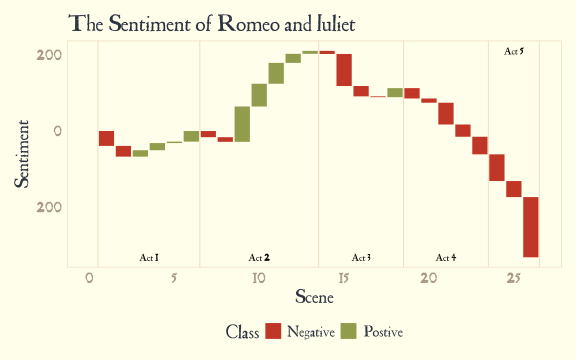

In [2]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

ggplot(filter(act_scene_sentiments, title == 'Romeo and Juliet'), aes(x = scene_order)) +
  geom_rect(aes(ymin = start, ymax = end, xmin = scene_order - 0.45, xmax = scene_order + 0.45, fill = sentiment > 0)) +
  geom_vline(data = filter(act_breaks, title == 'Romeo and Juliet'), aes(xintercept = scene_order), col = "#efe1c6") +
  geom_text(data = filter(act_labels, title == 'Romeo and Juliet'), aes(x = act_mid, label = label, y = position), size = 2, family = "Shakespeare First Folio Font") +
  labs(
    title = "The Sentiment of Romeo and Juliet",
    x = "Scene",
    y = "Sentiment",
    fill = "Class"
  ) +
  scale_x_continuous(breaks = pretty_breaks()) +
  scale_fill_pomological(labels = c("Negative", "Postive")) +
  expand_limits(x = 0) +
  theme_pomological(base_family = "Shakespeare First Folio Font", base_size = 11) +
  theme(legend.position = 'bottom', plot.subtitle = element_text(size = 8)) +
  theme(plot.margin = grid::unit(rep(5, 4), 'mm'))

If you are familiar with Romeo and Juliet, I hope you will agree that this plot quite accurately portrays the overall narrative arc of the play. We start with warring factions, which is then disrupted with hopes of love. This sentiment then grows to reach a climax at the end of the second act with marriage of the pair imminent. Sadly, from then on, it's only downhill, concluding with a mournful mutual-suicide in the last scene of the play.

Without knowledge of the play, picking out those details is admittedly impossible. Despite this, picking out the general turbulence of the story's sentiment, the climax of happiness in the middle and the eventual sad ending is complete feasible in one glance. Either way, we are left with a pretty visualisation.

I hope you enjoyed this post. I would encourage anyone to take the source code for this project (linked above) and apply it to other Shakespeare plays or entirely new sources. Who knows what interesting patterns you may find.